In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/top-instagram-influencers-data-cleaned/top_insta_influencers_data.csv
/kaggle/input/social-influence-on-shopping/WhatsgoodlyData-6.csv
/kaggle/input/uncovering-millennials-shopping-habits-and-socia/WhatsgoodlyData-6.csv
/kaggle/input/top-1000-social-media-channels/social media influencers-TIKTOK - ---DEC 2022.csv
/kaggle/input/top-1000-social-media-channels/social media influencers - Tiktok sep 2022.csv
/kaggle/input/top-1000-social-media-channels/social media influencers - Youtube sep-2022.csv
/kaggle/input/top-1000-social-media-channels/social media influencers-instagram june 2022 - june 2022.csv
/kaggle/input/top-1000-social-media-channels/social media influencers-youtube - --nov 2022.csv
/kaggle/input/top-1000-social-media-channels/social media influencers-tiktok - ---nov 2022.csv
/kaggle/input/top-1000-social-media-channels/social media influencers - instagram sep-2022.csv
/kaggle/input/top-1000-social-media-channels/social media influencers-tiktok june 2022 - june 2

In [21]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
from scipy.stats import ttest_ind

# Step 2: Load Dataset
# Replace with your dataset path
data = pd.read_csv("/kaggle/input/top-1000-social-media-channels/social media influencers - instagram.csv")

In [22]:
print(data.columns)


Index(['Influencer insta name', 'instagram name', 'category_1', 'category_2',
       'Followers', 'Audience country(mostly)', 'Authentic engagement\r\n',
       'Engagement avg\r\n'],
      dtype='object')


In [23]:
data.columns = data.columns.str.strip()  # Remove leading/trailing whitespace

# Convert numeric columns to appropriate types
data['Followers'] = pd.to_numeric(data['Followers'], errors='coerce')
data['Authentic engagement'] = pd.to_numeric(data['Authentic engagement'], errors='coerce')
data['Engagement avg'] = pd.to_numeric(data['Engagement avg'], errors='coerce')

# Check for missing values
print(data.isnull().sum())

Influencer insta name          0
instagram name                21
category_1                   108
category_2                   713
Followers                   1000
Audience country(mostly)      14
Authentic engagement         991
Engagement avg              1000
dtype: int64


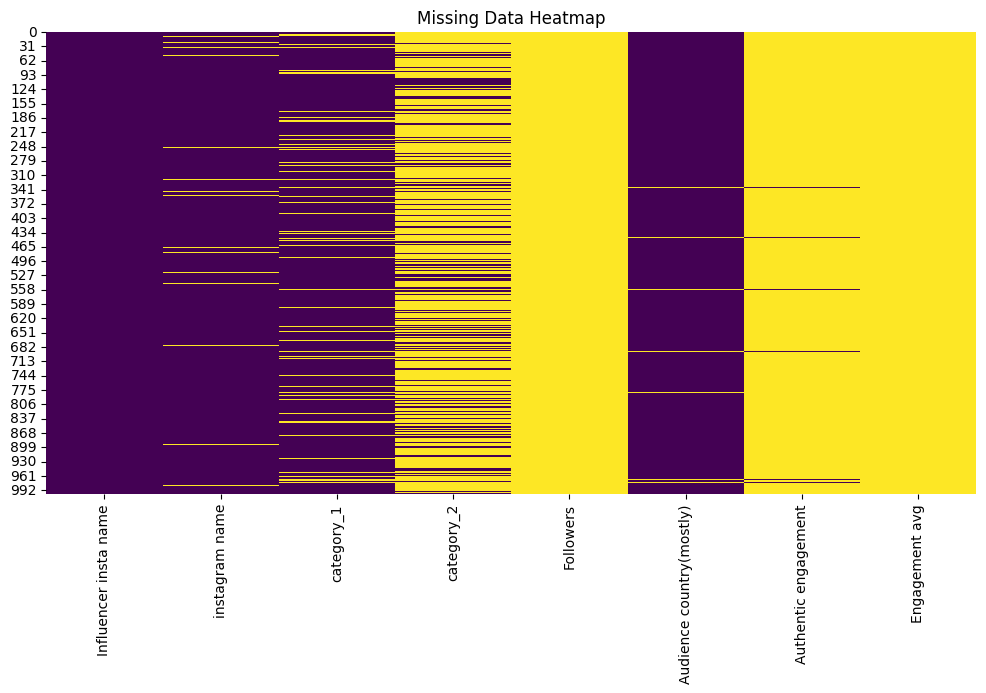

In [24]:
import seaborn as sns

# Visualize missing data pattern using heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

In [31]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/kaggle/input/top-1000-social-media-channels/social media influencers - instagram.csv'  # Replace with your file path
data = pd.read_csv(file_path)

In [32]:
# Clean column names
data.columns = data.columns.str.strip().str.replace(r'[\r\n]', '', regex=True)

# Convert 'Followers', 'Authentic engagement', and 'Engagement avg' to numeric values
for col in ['Followers', 'Authentic engagement', 'Engagement avg']:
    data[col] = (
        data[col]
        .str.replace('M', 'e6')
        .str.replace('K', 'e3')
        .astype(float)
    )

# Handle missing values by dropping rows with missing 'category_1' or 'instagram name'
data_cleaned = data.dropna(subset=['category_1', 'instagram name']).reset_index(drop=True)

# Combine category_1 and category_2 for keyword extraction
data_cleaned['combined_categories'] = data_cleaned['category_1'] + ' ' + data_cleaned['category_2'].fillna('')

# Extract keywords using CountVectorizer
vectorizer = CountVectorizer()
keywords_matrix = vectorizer.fit_transform(data_cleaned['combined_categories'])

# Convert keywords matrix to DataFrame
keywords_df = pd.DataFrame(
    keywords_matrix.toarray(),
    columns=vectorizer.get_feature_names_out()
)

# Combine numeric engagement metrics and keyword features
features = pd.concat([
    data_cleaned[['Followers', 'Authentic engagement', 'Engagement avg']],
    keywords_df
], axis=1)

# Normalize the features
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

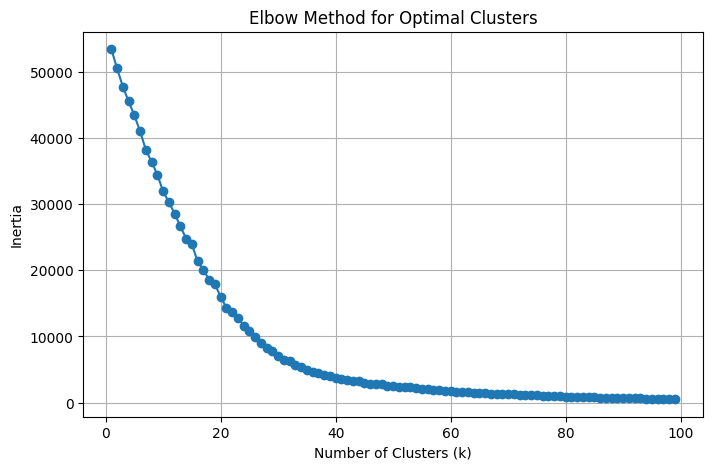

In [35]:
# Determine the optimal number of clusters using the Elbow method
inertia = []
cluster_range = range(1, 100)  # Test 1 to 10 clusters
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_normalized)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [36]:
# Apply K-means clustering with the optimal number of clusters (replace 'k' with the selected value)
optimal_k = 30 # Replace with the value chosen from the Elbow method
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data_cleaned['Cluster'] = kmeans.fit_predict(features_normalized)

# Analyze and save results
print(data_cleaned.groupby('Cluster')[['Followers', 'Authentic engagement', 'Engagement avg']].mean())
data_cleaned.to_csv('influencers_with_clusters.csv', index=False)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


            Followers  Authentic engagement  Engagement avg
Cluster                                                    
0        2.559348e+07          5.198391e+05    7.242174e+05
1        2.870609e+07          3.923461e+05    5.640817e+05
2        2.319958e+07          5.554616e+05    7.500295e+05
3        1.231429e+07          3.477429e+05    4.866000e+05
4        1.215500e+08          9.095000e+04    1.236500e+05
5        2.541667e+07          1.503000e+05    2.106167e+05
6        1.080000e+07          2.343000e+05    4.314000e+05
7        1.942800e+07          4.024280e+05    5.666760e+05
8        3.830000e+07          3.482500e+05    4.412667e+05
9        1.420000e+07          3.141833e+05    4.271167e+05
10       4.940000e+07          2.028000e+05    2.325500e+05
11       4.790000e+07          5.790000e+04    7.430000e+04
12       1.035000e+07          2.935000e+05    4.436500e+05
13       4.666364e+07          3.743636e+05    5.433182e+05
14       9.423333e+07          9.800000e

In [37]:
import scipy.stats as stats

# Perform hypothesis testing on engagement by category
category_engagement = data_cleaned[['category_1', 'Engagement avg']].dropna()

# Group engagement by category
grouped_engagement = [
    category_engagement[category_engagement['category_1'] == category]['Engagement avg']
    for category in category_engagement['category_1'].unique()
]

# Perform one-way ANOVA
anova_stat, p_value = stats.f_oneway(*grouped_engagement)

# Print results
print("Hypothesis Testing Results (Engagement by Category):")
print(f"ANOVA Statistic: {anova_stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Reject the null hypothesis: Engagement significantly differs between categories.")
else:
    print("Fail to reject the null hypothesis: No significant difference in engagement between categories.")

# Perform hypothesis testing on engagement by cluster
cluster_engagement = data_cleaned[['Cluster', 'Engagement avg']].dropna()

# Group engagement by cluster
grouped_cluster_engagement = [
    cluster_engagement[cluster_engagement['Cluster'] == cluster]['Engagement avg']
    for cluster in cluster_engagement['Cluster'].unique()
]

# Perform one-way ANOVA
anova_stat_clusters, p_value_clusters = stats.f_oneway(*grouped_cluster_engagement)

# Print results
print("\nHypothesis Testing Results (Engagement by Cluster):")
print(f"ANOVA Statistic: {anova_stat_clusters}")
print(f"P-value: {p_value_clusters}")

if p_value_clusters < 0.05:
    print("Reject the null hypothesis: Engagement significantly differs between clusters.")
else:
    print("Fail to reject the null hypothesis: No significant difference in engagement between clusters.")


Hypothesis Testing Results (Engagement by Category):
ANOVA Statistic: 1.047701759084795
P-value: 0.3974483010885188
Fail to reject the null hypothesis: No significant difference in engagement between categories.

Hypothesis Testing Results (Engagement by Cluster):
ANOVA Statistic: 27.83142283267491
P-value: 9.437101217439954e-103
Reject the null hypothesis: Engagement significantly differs between clusters.
